In [1]:
from matplotlib import pyplot as plt
import numpy as np
from netCDF4 import Dataset
import netCDF4
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
import pandas as pd
import pickle
import gsw
import cftime



SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [2]:
#constant
path='/storage/jlavoie/Research/Data/Budget/'
fTEMP=Dataset(path+'b.e11.BRCP85C5CNBDRD.f09_g16.002.pop.h.TEMP.200601-208012.nc')
fTEMP1=Dataset(path+'b.e11.B20TRC5CNBDRD.f09_g16.002.pop.h.TEMP.192001-200512.nc')
faice=Dataset(path+'b.e11.BRCP85C5CNBDRD.f09_g16.002.cice.h.aice_nh.200601-208012.nc')

months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
nbDaysInMonth=[31,28,31,30,31,30,31,31,30,31,30,31]

rho_sw=fTEMP['rho_sw'][:]*1000#kg m-3
cp_sw=fTEMP['cp_sw'][:]*0.0001#J kg-1 K-1
T2E=rho_sw*cp_sw#J degC-1 m-3

latent_heat_vapor=fTEMP['latent_heat_vapor'][:]
latent_heat_fusion=fTEMP1['latent_heat_fusion'][:]*1e-7*1000# erg/g -> J/kg
rho_ice=917#kg/m3

dz=fTEMP['dz'][:]*0.01# m
dzw=fTEMP['dzw'][:]*0.01# m
Tf=-1.8
tlong=fTEMP['TLONG'][:]
tlat=fTEMP['TLAT'][:]
tlon=faice['TLON'][:]
tla=faice['TLAT'][:]
z_t=fTEMP['z_t'][:]*0.01#m
z_w=fTEMP['z_w'][:]*0.01#m
z_w_top=fTEMP['z_w_top'][:]*0.01#m
z_w_bot=fTEMP['z_w_bot'][:]*0.01#m


timeDay1=fTEMP1['time']
Jan1920=cftime.DatetimeNoLeap(1920, 1, 1, 0, 0, 0, 0, 0, 0)
time1 = netCDF4.num2date(timeDay1[:],timeDay1.units,calendar=timeDay1.calendar)
time1=[Jan1920]+list(time1[:-1])
time_boundDay1=fTEMP1['time_bound']
time_bound1 = netCDF4.num2date(time_boundDay1[:],timeDay1.units,calendar=timeDay1.calendar)
ind1970, ind1980= 600,720

timeDay=fTEMP['time']
time = netCDF4.num2date(timeDay[:],timeDay.units,calendar=timeDay.calendar)
#fix month error in cesm
Jan2006=cftime.DatetimeNoLeap(2006, 1, 1, 0, 0, 0, 0, 0, 0)
time=[Jan2006]+list(time[:-1])
time_boundDay=fTEMP['time_bound']
time_bound = netCDF4.num2date(time_boundDay[:],timeDay.units,calendar=timeDay.calendar)
ind2010=12*4
ind2020=12*14




# create mask CB
maskCBocn=np.zeros((384,320))
for i in range(384):
    for j in range(320):
        if  205<=tlong[i,j]<=230 and 72<=tlat[i,j]<=80:
            maskCBocn[i,j]=1
            
maskCBice=np.zeros((104,320))
for i in range(104):
    for j in range(320):
        if  205<=tlon[i,j]<=230 and 72<=tla[i,j]<=80:
            maskCBice[i,j]=1


pathSaved='/storage/jlavoie/Research/Data/saved/'
with open(pathSaved+"ajProfiles.txt", "rb") as fp:  
    ajProfiles=pickle.load(fp)
print('ajloaded!')
with open(pathSaved+"itpProfiles.txt", "rb") as fp:  
    itpProfiles=pickle.load(fp)
print('itploaded!')
z_O=ajProfiles[0]['D']


ajloaded!
itploaded!


In [3]:
pathCESM='/storage/jlavoie/Research/Data/CESM-LE/'

#list of string with numberof EM
EM=['00'+str(i) if i<10 else  '0'+str(i) if i<100 else ' '   for i in range(1,36)] +[str(i) for i in range(101,106)]
#cesm variable needed to calculate the flux of element of the budget
varByPro={'SiO3':['SiO3']}

In [4]:
#"""
#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std
nutrient_40=[{'SiO3':[]},{'SiO3':[]}]

ind1948, ind2000=336,960


nutrientMean=[]
nutrientStd=[]
nutrientMax=[]
nutrientMin=[]

blockNans=np.zeros((120, 249, 60))
blockNans[blockNans==0]=np.nan
t=3
timeBD=time_boundDay[(12*t)+11:(12*t)+25]# get time for right window
DeltaTime=[(x[1]-x[0])*86400 for x in timeBD]# nb of days in the months and put in sec

for p in range(1):# iterate between 2 periods
    if p==0:
        indA,indB=ind1970,ind1980
        run='B20TRC5CNBDRD'

        
    else:
        indA,indB=ind2010,ind2020
        run='BRCP85C5CNBDRD'
        
    for em in EM[1::]:
        if int(em) not in [3,4,5,6,7,8,27]:
            print(em)
            for f in ['SiO3']:
                varNeeded=[]
                for var in varByPro[f]:
                    #specifics of filename
                    model='pop'
                    varHemi=var
                    if var[0].islower():
                        model='cice'
                        varHemi=var+'_nh'#add hemisphere for name of file
                    push1920=0
                    if p==0:
                        if em=='001':
                            date='185001-200512'
                            push1920=840#push index to start at 1920 not 1850
                        else:
                            date='192001-200512'          
                    else:
                        if int(em)>=34 and p==1:
                            date='200601-210012'
                        else:
                            date='200601-208012'
                    fileEM=Dataset(pathCESM+var+'/b.e11.'+run+'.f09_g16.'+em+'.'+model+'.h.'+varHemi+'.'+date+'.nc')
                    cutVar=fileEM[var][ind1948+push1920:ind2000+push1920,:,-104:]# cut like this because it is faster
                    varNeeded.append(cutVar)
                    # take JAS at 75m
                    data_CB_all=[varNeeded[0][m::12,7] for m in range(12)][6:9]

                # average over JAS and years
                nutrient_40[p][f].append(np.nanmean(data_CB_all,axis=(0,1)))


    
    for f in nutrient_40[p]:
        nutrient_40[p][f]=np.array(nutrient_40[p][f])


    meanP={}
    stdP={}
    maxP={}
    minP={}
    for f in nutrient_40[p]:
        meanP[f]=np.nanmean(nutrient_40[p][f],axis=0)
        stdP[f]=np.nanstd(nutrient_40[p][f],axis=0)
        maxP[f]=np.nanmax(nutrient_40[p][f],axis=0)
        minP[f]=np.nanmin(nutrient_40[p][f],axis=0)
    nutrientMean.append(meanP)
    nutrientStd.append(stdP)
    nutrientMax.append(maxP)
    nutrientMin.append(minP)

    #"""

002


/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
028
029
030
031
032
033
034
035
101
102
103
104
105


/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1503: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


Text(0.5, 1.0, 'b) Observations')

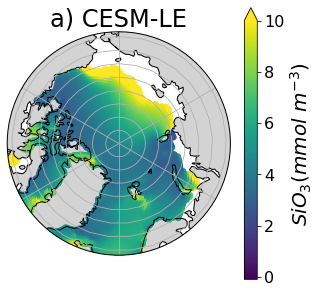

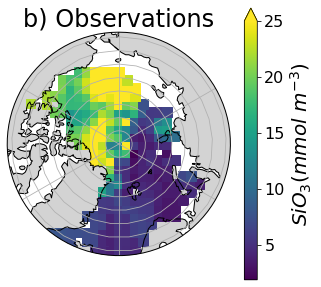

In [5]:
fig = plt.figure(figsize=[5,5])
ax = plt.subplot( projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180,65, 90], ccrs.PlateCarree())
ax.gridlines()
ax.add_feature(cartopy.feature.COASTLINE)
ax.set_boundary(circle, transform=ax.transAxes)

scat=ax.scatter(tlon,tla,c=nutrientMean[0]['SiO3'], s=25,
                transform= ccrs.PlateCarree(),vmax=10)
ax.add_feature(cartopy.feature.LAND,color='lightgray')
cb=plt.colorbar(scat,label='$SiO_3$($mmol$ $m^{-3}$)',extend='max')
ax.set_title('a) CESM-LE')


obs75=pd.read_csv('saved/SUM_SIL_0075.txt',delim_whitespace=True)

fig = plt.figure(figsize=[5,5])
ax = plt.subplot( projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180,65, 90], ccrs.PlateCarree())
ax.gridlines()
ax.add_feature(cartopy.feature.COASTLINE)
ax.set_boundary(circle, transform=ax.transAxes)
scat=ax.scatter(obs75['LONGITUDE'],obs75['LATITUDE'],c=obs75['VALUES'],s=90,marker='s',
                transform= ccrs.PlateCarree(),vmax=25)
ax.add_feature(cartopy.feature.LAND,color='lightgray')
cb=plt.colorbar(scat,label='$SiO_3$($mmol$ $m^{-3}$)',extend='max')
plt.title('b) Observations')